# Семантическая Сегментация. Часть 3.

# Домашнее задание

### Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

## 1. Подключение библиотек

In [1]:
import os
import skimage.io as io
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Input, Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17176231023490676152, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12814561966735885652
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10287721839154123866
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7304675328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11916445577863437210
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

## 2. Загрузка датасета COCO и COCO API (распаковка идет быстрее на колабовском жестком, а не на gdrive и, видимо, работает стабильнее)

In [4]:
!mkdir -p data

In [5]:
!cd data && wget http://images.cocodataset.org/zips/train2017.zip

--2020-07-25 04:51:09--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.25.52
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.25.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  27.1MB/s    in 7m 31s  

2020-07-25 04:58:40 (40.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [6]:
!cd data && unzip -q train2017.zip

In [9]:
!cd data && rm train2017.zip

In [10]:
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 

--2020-07-25 05:09:15--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.38.108
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.38.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  50.4MB/s    in 14s     

2020-07-25 05:09:28 (57.3 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [11]:
!cd data && unzip -q val2017.zip

In [12]:
!cd data && rm val2017.zip

In [13]:
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-07-25 05:10:31--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.165.115
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.165.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  93.4MB/s    in 2.6s    

2020-07-25 05:10:33 (93.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [14]:
!cd data && unzip -q annotations_trainval2017.zip

In [16]:
!cd data && rm annotations_trainval2017.zip

In [17]:
!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (576/576), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-pac

In [18]:
!ls data/

annotations  cocoapi  train2017  val2017


## 3. Подготовка COCO API

In [19]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## 4. Универсальный класс Dataset для сегментации

In [23]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        #dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## 5. Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [24]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [25]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=15.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [26]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 5

In [27]:
train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, EPOCHS, IMG_HEIGHT)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, IMG_HEIGHT)

## 6. Создание модели

In [28]:
! pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-33i5mckd
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-33i5mckd
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18398 sha256=1a406aea480898e8ddfdb6a016f99b084dbb48cf40dd5130efcca834534eeec5
  Stored in directory: /tmp/pip-ephem-wheel-cache-9el_nrez/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [29]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lixi6qug
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-lixi6qug
  Created wheel for tensorflow-examples: filename=tensorflow_examples-335ab713ed7361f0a476c457eb4fe557e435d72d_-cp36-none-any.whl size=134284 sha256=50522b656fda3e2b4929cec662b1bbb71e5d01ccf0177bd218a0fc83cb13e938
  Stored in directory: /tmp/pip-ephem-wheel-cache-ec9h4c87/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.4MB 14.4MB/s 


In [30]:
from tensorflow_examples.models.pix2pix import pix2pix

In [31]:
import efficientnet.tfkeras as efn

In [32]:
model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)

71892992/71892840 [==============================] - 1s 0us/step


In [33]:
model.trainable = False

In [34]:
up_stack = [
    pix2pix.upsample(224, 3),  # 8x8 -> 16x16
    pix2pix.upsample(80, 3),  # 16x16 -> 32x32
    pix2pix.upsample(48, 3),  # 32x32 -> 64x64
    pix2pix.upsample(32, 3),   # 64x64 -> 128x128
]

In [35]:
layer_names = [
    'stem_conv',     # 128x128 48
    'block2b_add',   # 64x64 32
    'block3b_add',   # 32x32 56
    'block5b_add',   # 16x16 160
    #'block6b_add ',  # 8x8 272
    'top_activation',      # 8x8 1792 (top)
]

In [36]:
layers = [model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=model.input, outputs=layers)

down_stack.trainable = False

In [37]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]

  #x = tf.keras.layers.Conv2D(1024, 3, strides=(1, 1), padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(512, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)
  x = tf.keras.layers.Conv2D(256, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)

  x = up_stack[0](x)
  x = tf.keras.layers.Concatenate()([x, skips[3]])
  x = tf.keras.layers.Conv2D(128, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  x = up_stack[1](x)
  x = tf.keras.layers.Concatenate()([x, skips[2]])
  x = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  x = up_stack[2](x)
  x = tf.keras.layers.Concatenate()([x, skips[1]])
  x = tf.keras.layers.Conv2D(64, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  x = up_stack[3](x)
  x = tf.keras.layers.Concatenate()([x, skips[0]])
  x = tf.keras.layers.Conv2D(32, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)
  x = tf.keras.layers.Conv2D(16, 3, strides=(1, 1), padding='same', activation='swish', kernel_initializer='he_normal')(x)


  # This is the last layer of the model
  #last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2,padding='same')  #64x64 -> 128x128

  
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2,padding='same', activation='sigmoid')  #128x128 -> 256x256
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [38]:
OUTPUT_CHANNELS = 1
model = unet_model(OUTPUT_CHANNELS)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 128, 128, 48 17673816    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 512)    8258048     model[1][4]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 256)    1179904     conv2d[0][0]                     
____________________________________________________________________________________________

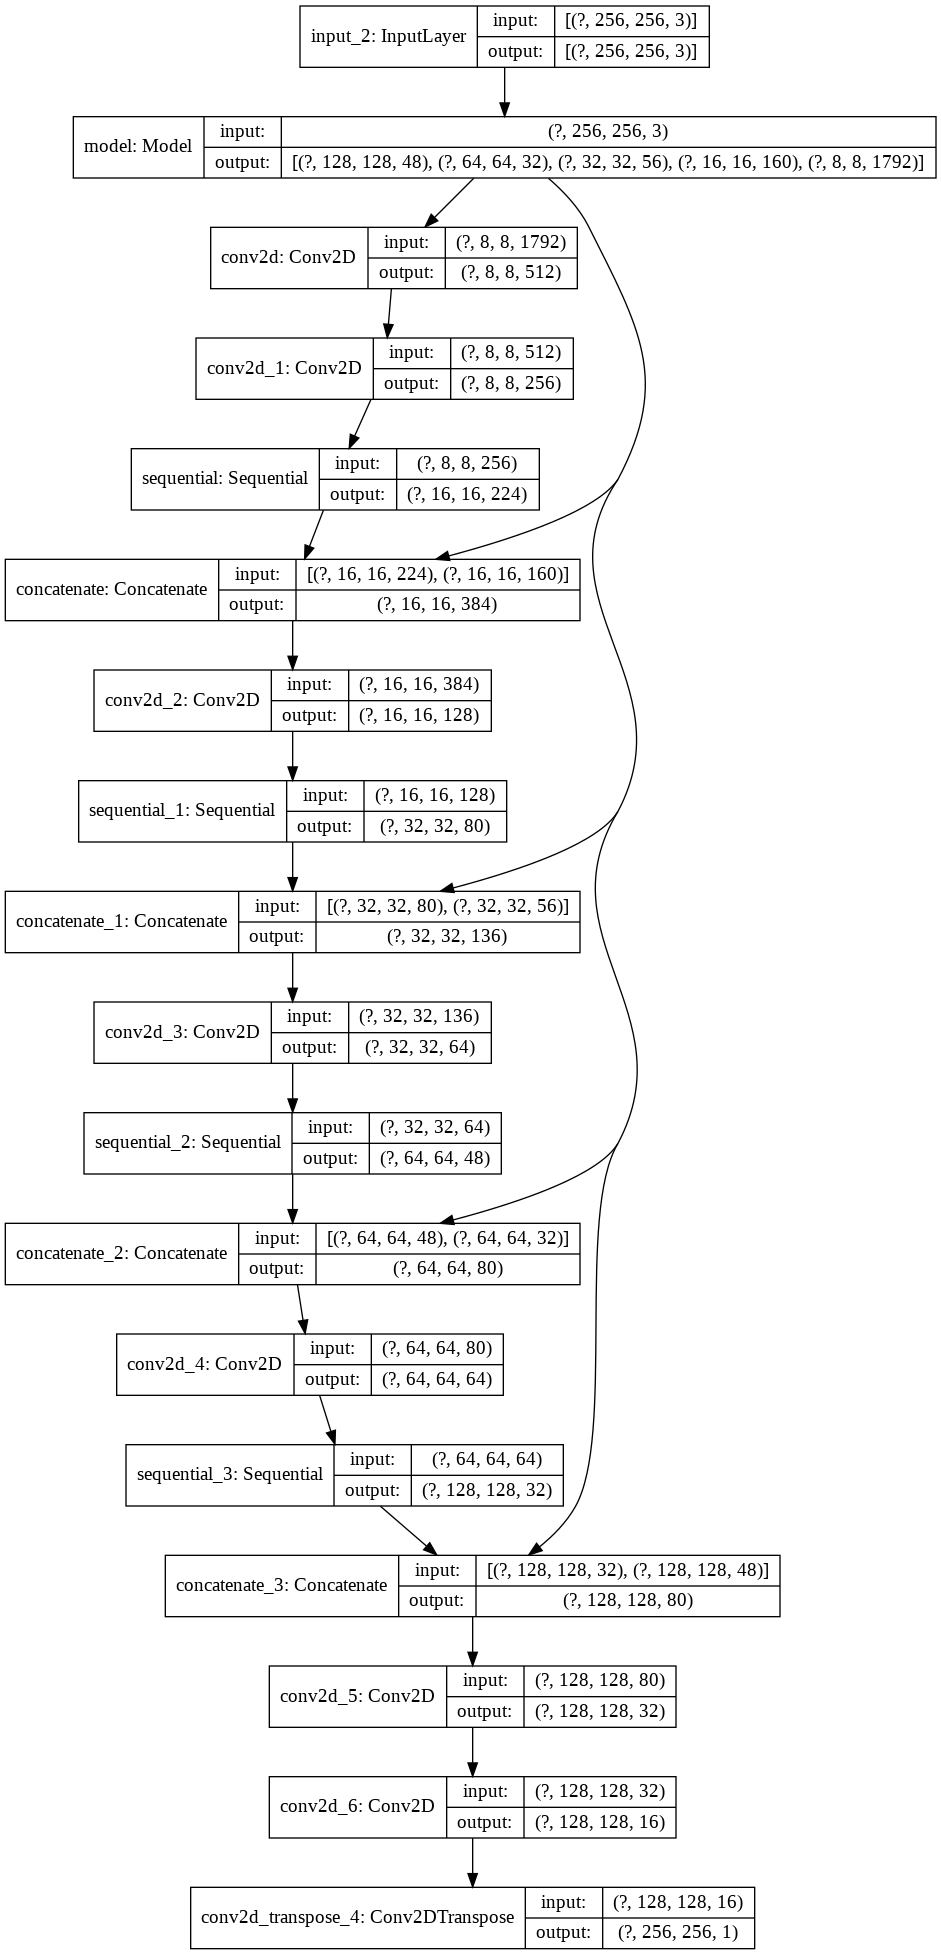

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 7. Обучение

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = 'accuracy')

hist = model.fit(train_ds, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = val_ds)

Epoch 1/5
1001/1001 [==============================] - 1260s 1s/step - loss: 0.1834 - accuracy: 0.9237 - val_loss: 0.1564 - val_accuracy: 0.9385
Epoch 2/5
1001/1001 [==============================] - 1251s 1s/step - loss: 0.1487 - accuracy: 0.9406 - val_loss: 0.1574 - val_accuracy: 0.9368
Epoch 3/5
1001/1001 [==============================] - 1243s 1s/step - loss: 0.1432 - accuracy: 0.9429 - val_loss: 0.1464 - val_accuracy: 0.9419
Epoch 4/5
1001/1001 [==============================] - 1244s 1s/step - loss: 0.1378 - accuracy: 0.9450 - val_loss: 0.1400 - val_accuracy: 0.9450
Epoch 5/5
1001/1001 [==============================] - 1242s 1s/step - loss: 0.1348 - accuracy: 0.9460 - val_loss: 0.1404 - val_accuracy: 0.9458


In [42]:
model.evaluate(val_ds)

42/42 [==============================] - 42s 1s/step - loss: 0.1404 - accuracy: 0.9458


[0.140382319688797, 0.9457676410675049]